## Тарабонда Герман

### Задание № 5

### (А)

Для начала найдем $f(x)$:

$f(x) = -u''(x) + xu(x) = -(x(1-x)e^x)'' +x^2(1-x)e^x = (x^2+3x)e^x + (x^2-x^3)e^x = -x(x^2-2x-3)e^x$

И теперь сформируем матрицу $A$ и вектор $\vec{b}$:

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import time
from typing import List, Tuple, Callable, NoReturn

In [2]:
def calculate_f(x: float) -> float:
    return -x * (x * x - 2 * x - 3) * np.exp(x)

def calculate_u(x: float) -> float:
    return x * (1 - x) * np.exp(x)

def calculate_h(N: int) -> float:
    return 1 / (N + 1)

def calculate_u_vec(N: int) -> np.array:
    h = calculate_h(N)
    return np.array([calculate_u(i * h) for i in range(1, N + 1)])

def calculate_b_vec(N: int) -> np.array:
    h = calculate_h(N)
    return np.array([calculate_f(i * h) for i in range(1, N + 1)])

def calculate_A_mat(N: int) -> np.array:
    A = np.zeros((N, N))
    h = calculate_h(N)
    for i in range(N):
        A[i][i] = i * h + 2 / (h * h)
    for i in range(N - 1):
        A[i][i + 1] = - 1 / (h * h)
    for i in range(N - 1):
        A[i + 1][i] = - 1 / (h * h)
    return A

def caclulate_and_measure_time(func: Callable[[np.array, np.array], np.array], # func(A, b) -> u
                              A: np.array, b: np.array) -> Tuple[np.array, float]:
    start_time = time.time()
    u = func(A, b)
    measured_time = time.time() - start_time
    return (u, measured_time)

In [3]:
def plot_subplot(subplot: matplotlib.axes._base._AxesBase,
                 X: List[float], Y: List[float],
                 color: str, ylabel: str,
                 title: str) -> NoReturn:
    subplot.plot(X, Y, color=color)
    subplot.grid()
    subplot.set_ylabel(ylabel)
    subplot.set_title(title)

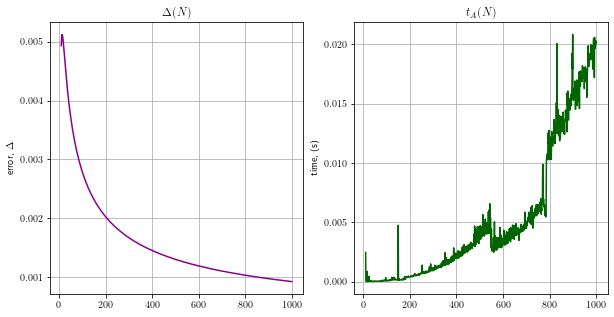

In [4]:
Ns = range(10, 1001)
[u_As, timings_A] = map(
    list,
    zip(*[
        caclulate_and_measure_time(
            np.linalg.solve,
            calculate_A_mat(N),
            calculate_b_vec(N)
        ) 
        for N in Ns
    ])
)
u_reference = [calculate_u_vec(N) for N in Ns]
delta_u_A = [np.linalg.norm(u_As[i] - u_reference[i]) for i, _ in enumerate(u_As)]

_, (plt1, plt2) = plt.subplots(1, 2, figsize=(10,5))
plot_subplot(plt1, Ns, delta_u_A, 'darkmagenta', 'error, $\Delta$', '$\Delta(N)$')
plot_subplot(plt2, Ns, timings_A, 'darkgreen', 'time, (s)', '$t_A(N)$')
plt.show()

Заметим, что погрешность вычислений уменьшается с ростом $N$, а время в свою очередь увеличивается

### (B)

Для начала проверим, можно ли пользоваться методом прогонки. Для этого нужно, чтобы $\forall k: |c_k| > |a_k| + |b_k|$

$2h^{-2} + ih > |-h^{-2}| + |-h^{-2}| \Rightarrow ih > 0$, а это всегда верно, значит методом прогонки пользоваться можно

In [5]:
def get_alphas_and_betas(a: np.array, b: np.array,
                         c: np.array, s: np.array) -> Tuple[np.array, np.array]:
    N = s.shape[0]
    
    alphas = np.zeros(N)
    betas = np.zeros(N)
    
    alphas[0] = b[0] / c[0]
    betas[0] = s[0] / c[0]
    
    for i in range(1, N):
        alphas[i] = b[i] / (c[i] - alphas[i - 1] * a[i])
        
    for i in range(1, N):
        betas[i] = (s[i] + betas[i - 1] * a[i]) / (c[i] - alphas[i - 1] * a[i])
        
    return (alphas, betas)

def get_ans_vec(alphas: np.array, betas: np.array) -> np.array:
    N = alphas.shape[0]
    t = np.zeros(N)
    t[N - 1] = betas[N - 1]
    for i in reversed(range(N - 1)):
        t[i] = alphas[i] * t[i + 1] + betas[i]
        
    return t

def sweep_method(A: np.array, s: np.array) -> np.array:
    N = s.shape[0]
    
    a = np.zeros(N)
    for i in range(N - 1):
        a[i + 1] = -A[i + 1][i]
    
    b = np.zeros(N)
    for i in range(N - 1):
        b[i] = -A[i][i + 1]
        
    c = np.array([A[i][i] for i in range(N)])
    
    alphas, betas = get_alphas_and_betas(a, b, c, s)
    return get_ans_vec(alphas, betas)
    

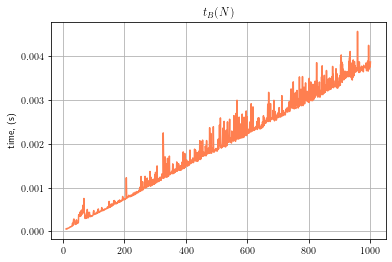

In [6]:
[u_Bs, timings_B] = map(
    list,
    zip(*[
        caclulate_and_measure_time(
            sweep_method,
            calculate_A_mat(N),
            calculate_b_vec(N)
        ) 
        for N in Ns
    ])
)

plt.plot(Ns, timings_B, color='coral')
plt.grid()
plt.ylabel('time, (s)')
plt.title('$t_B(N)$')
plt.show()

Заметим, что в пункте $A$ время возрастает довольно быстро, так как имеет кубическую зависимость от количества элементов, в отличии от пункта $B$. Здесь видна линейная зависимость времени от количества элементов

### (C)

Для начала проверим можно ли здесь воспользоваться методом Якоби. Для этого нужно проверить условие:

$\forall i \in [1..N] \;|a_{ii}| > \sum\limits_{j=1,j\neq i}^{N} |a_{ij}|$

Для нашей матрицы в худшем случае:

$|2h^{-2} + ih| > |-h^{-2}| + |-h^{-2}|$, что правда (проверялось в пункте B)

Значит мы можем воспользоваться данным методом

In [7]:
def decompose_matrix(A: np.array) -> Tuple[np.array, np.array]:
    D = np.zeros(A.shape)
    np.fill_diagonal(D, A.diagonal())
    
    B = A - D
    D_1 = np.linalg.inv(D)
    
    return (B, D_1)

def Jacobi_method(A: np.array, b: np.array, m: int) -> List[np.array]:
    N = b.shape[0]
    B, D_1 = decompose_matrix(A)
    x = np.random.sample(N)
    
    iters = []
    for i in range(m):
        x_next = D_1.dot(b) - D_1.dot(B.dot(x))
        iters.append(x_next)
        x = x_next
        
    return iters

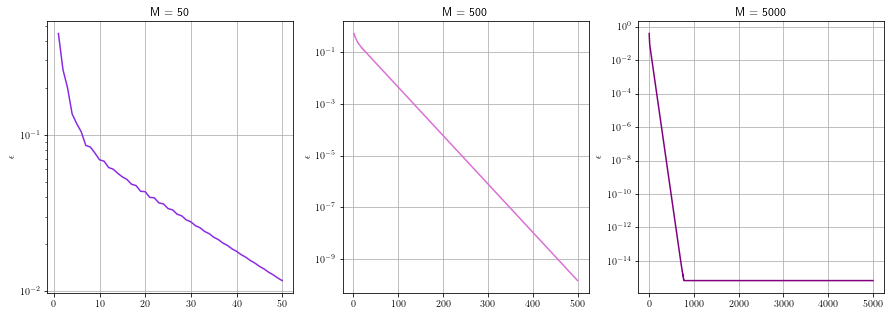

In [8]:
Ms = [50, 500, 5000]
colors = ['blueviolet', 'orchid', 'purple']
A_C = calculate_A_mat(10)
b_C = calculate_b_vec(10)
u_C = np.linalg.solve(A_C, b_C)

_, plts = plt.subplots(1, 3, figsize=(15,5))

for i, M in enumerate(Ms):
    u_res = Jacobi_method(A_C, b_C, M)
    iter_num = range(1, M + 1)
    iter_eps = [np.abs(u - u_C).max() for u in u_res]
    plot_subplot(plts[i], iter_num, iter_eps, colors[i], '$\epsilon$', f'M = {M}')
    plts[i].set_yscale('log')

Можно заметить, что ошибка уменьшается экспоненциально, как примерно и препдполагалось. И данный метод сходится довольно быстро, так как уже примерно на 800-ой итерации ошибка была нулевой.